# Figure S2 from Villas Boas et al., 2021 - Geophysical Research Letters

#### Data used:
- MASS sea surface height anomaly

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../src')

import glob
import numpy as np
import xarray as xr
from scipy.io import loadmat
from tools import *

import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

Not that, despite being a bit slow, everything should run without spinning up a cluster. If you don't have multiple cores available, comment the cell below. 

### Loading data from the April 9, 2019 flights

Loading binned point cloud for upwind and crosswind for the April 9 flights

In [2]:
binned_up03 = '../data/MASS/20190328/binned_point_cloud/upwind/*.nc'
dsu03 = xr.open_mfdataset(binned_up03, concat_dim='time', chunks={'time':9})

Computing the spectra and spectral uncertainities. The cells below used functions from ../src/tools.py

In [3]:
dim = 'atrack_bin'

dau03 = dsu03.ssh_corr
specu03 = spec_xr(dau03, dim)
specu_dani03,  box_widthu03 = daniell(specu03, dim='freq_atrack_bin',
                                  npoints=20, start_freq=1e-4)
psdu03 = specu_dani03.mean(dim='time')/1e3

specu_dani_norm03 = specu_dani03/specu_dani03.max()
psdu_norm03 = specu_dani_norm03.mean(dim='time')

nu_u03 =  2* specu_dani03.time.size * box_widthu03
error_lowu03, error_highu03 = spec_error(nu_u03)

Compute the transfer function for a Blackman-Haris window with feature resolution of 250m, 500m, and 1km

In [4]:
n250 = 453
n500 = 907
n1000 = 1815

ndata = len(dau03.atrack_bin)
freq, amp_black250 = window_fft(n250, ndata, window='blackman')
freq, amp_black500 = window_fft(n500, ndata, window='blackman')
freq, amp_black1000 = window_fft(n1000, ndata, window='blackman')

Filters the SSH spectrum using a Blackman-Haris window with feature resolution of 250m, 500m, and 1km

In [5]:
cutoff = [1, 250, 500, 1000]
n_black = [1, 453, 907, 1815 ]
window = 'blackman'
black_up, spec_up_black250 = filtered_spectra(dau03, npts=n_black, window=window, decimate=250)

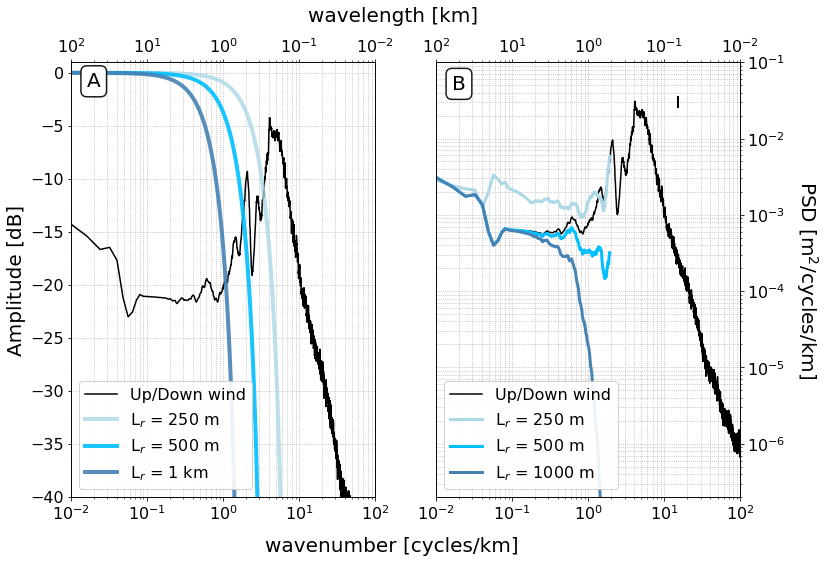

In [6]:
elu, ehu = error_lowu03[-1], error_highu03[-1]
colors = {'1':'k', '250':'lightblue', '500':'deepskyblue', '1000':'steelblue'}


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,8))
ax1.semilogx(specu_dani03.freq_atrack_bin*1e3, 10*np.log10(psdu_norm03),
             color='k', label='Up/Down wind')
ax1.semilogx(freq*1e3, 10*np.log10(amp_black250), color='lightblue',
            alpha = 0.8, label='L$_r$ = 250 m', lw=4)
ax1.semilogx(freq*1e3, 10*np.log10(amp_black500), color='deepskyblue',
            lw=4, alpha = 0.9, label='L$_r$ = 500 m')
ax1.semilogx(freq*1e3, 10*np.log10(amp_black1000), color='steelblue',
            lw=4, alpha = 0.9, label='L$_r$ = 1 km')
ax1.grid(which='both', ls='dotted')
ax1.legend(loc='best', framealpha=0.9)
add_second_axis_window(ax1)
ax1.set_ylim([-40, 1])
ax1.set_xlim([1e-2, 1e2])
ax1.set_ylabel('Amplitude [dB]', fontsize=20)

ax2.loglog(specu_dani03.freq_atrack_bin*1e3, psdu03, color='k', label='Up/Down wind')
for dbin in [250, 500, 1000]:
    ax2.loglog(spec_up_black250['ssha_spec{}'.format(dbin)].freq_atrack_bin*1e3,
               spec_up_black250['ssha_spec{}'.format(dbin)].mean(dim='time')*1e-3,
               color=colors[str(dbin)],  lw=3, label = 'L$_r$ = {} m'.format(dbin))
ax2.semilogx([15, 15], [elu*3e-2, ehu*3e-2], 'k', lw=2)
ax2.grid(which='both', ls='dotted')
ax2.legend(loc=3, framealpha=0.9)
ax2.set_xlim([1e-2, 1e2])
ax2.set_ylim([2e-7, 1e-1])
ax2.set_xticks([1e-2, 1e-1, 1, 10, 1e2])
ax2.yaxis.tick_right()
ax2.set_ylabel('PSD [m$^2$/cycles/km]', fontsize=20, rotation=270, labelpad=34)
ax2.yaxis.set_label_position("right")
add_second_axis_window(ax2)
fig.text(0.35, 0.03, 'wavenumber [cycles/km]', fontsize=20)
fig.text(0.4, 0.95, 'wavelength [km]', fontsize=20)

bbox_props = dict(boxstyle="round", fc="w", lw=1.5, ec="0.1", alpha=1)
ax1.text(2e-2, -0.8, "A", ha="center", va="center", size=20,
        bbox=bbox_props)
ax2.text(2e-2, 5.2e-2, "B", ha="center", va="center", size=20,
        bbox=bbox_props)
plt.savefig('../figs/figS2.png',
            dpi=150, bbox_inches='tight', facecolor="w" )